In [1]:
import sys
sys.path.append("/Users/octavia/Dropbox/SVE_v2/utilities")
sys.path.append("/Users/octavia/Dropbox/SVE_v2/model")


my_modules = ['plot_functions', 'load_model_output', 'search_functions']
for mod in my_modules:
    if mod in sys.modules: 
        del sys.modules[mod]


from search_functions import *
from load_model_output import *
from plot_functions import *
from plot_3D_functions import *

In [2]:
import ipywidgets as widgets
dirs = os.listdir(os.path.join(project_dir , 'model_output/'))
dirs = list(set(dirs) - {'.DS_Store'})

select_base_name = widgets.Dropdown(
    options=dirs,
    description='base_name:',
    disabled=False,
)
select_base_name

Dropdown(description='base_name:', options=('test_topo_flat', 'test_veg', 'test_inflow', 'test_topo', 'test_GW…

In [3]:
## SELECTION OPTIONS
# selectB = get_widget()
# selectB
# selectA = get_widget()
# selectA
# keyA = selectA.value
# print(keyA)
# keyB = selectB.value
# print(keyB)

In [4]:
project_dir = "/Users/octavia/Dropbox/SVE_v2/"
base_name = select_base_name.value
base_dir = os.path.join(project_dir, 'model_output', base_name )

print_input_params(base_dir, ["dx", "Lx", "Ly"])

batch:
	dt_sw : 0.001
sim:
	m_sigma : 2, 1
	m_So : 0.1, 0.01
	m_edge : 20, 10
common:
	H_i : 0.0
	dx : 2
	Lx : 100
	Ly : 100


In [5]:
core = load_sims(base_dir)
# core = patchy_update(core)
core.runtime_hr.max()

1.3340668894444445

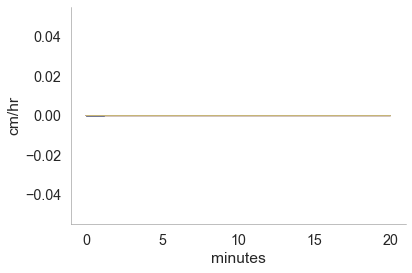

In [6]:
fig = plot_hydrographs(core[:20])

In [7]:
dum = filter_core(core, criteria = {"Ks" : 5, "p" : 5}, quality = None)


In [8]:
name_vars = get_name_vars(base_dir)
names =  get_name_tuples(core, name_vars)

def get_widget():
    select = widgets.Dropdown(
        options=names,
        description='Name:')
    return select

In [9]:
# def patchy_update(core):
#     """

#     TODO: delete
#     """
#     sims = dict(core.T)

#     for key in sims.keys():
#         sim = pd.Series(sims[key])
#         sims[key] = pd.Series(sims[key])
#         if "xflux0" not in sim:        
#             sims[key]['qc'] =  sim.uc * sim.hc
#         else:   
#             sims[key]['qc'] =  sim.xflux0/sim.dx
            
#         sims[key]['qc_1D'] = sims[key]['qc'].mean(1)


#     core = pd.DataFrame(sims).T

#     return core


In [10]:
def compute_Lv(sim, x_f = None):
    """
    patchy code: yet to be developed, draw on ravel_functions_RF.
    """
    Lv = sim.veg.mean(0).sum() * sim.dx
    if x_f is not None:
        Lv = sim.veg.mean(0)[:x_f].sum() * sim.dx                          
    return Lv

def compute_Lb(sim):
    """
    Todo: refine for patchy code; assumes manning
    """
    Lb = (sim.ncol - sim.veg.mean(0).sum()) * sim.dx
    return Lb

def compute_Ta(sim, x_f = None):
    """
    Compute activation time 
    
    TODO: reference Brutsaert
    """
    
    Lv = compute_Lv(sim, x_f)
    alpha = sim.alpha
    Kr_v = sim.So ** .5 / alpha
    Kr_b = sim.So ** .5 / sim.alphaB
    Lb =  compute_Lb(sim)

    m = sim.m
    rain = sim.rain    

    T_a = (Lb / Kr_b / rain ** m) ** (1. / (m + 1)) /60
    return T_a

def compute_Tc(sim, x_f = None):
    """
    Compute conveyance time
    Assume a bare soil area upslope of a vegetated one
    """
    Lv = compute_Lv(sim, x_f)
    alpha = sim.alpha
    Kr_v = sim.So ** .5 / alpha
    Lb =  compute_Lb(sim)

    m = sim.m
    rain = sim.rain    
    
    T_c = Lv * Kr_v ** (-1. / (m + 1)) * (Lb * rain) ** (-m / (m + 1.)) /60
    return T_c



In [11]:
def patchy_summary(sim, x_f = None):
        
    smry = pd.Series({
        "Lb" : compute_Lb(sim),
        "Lv" : compute_Lv(sim, x_f),
        "T_C" : compute_Tc(sim, x_f),
        "T_A" : compute_Ta(sim, x_f) })
    smry["Ta_Tc"] = smry["T_A"]/smry["T_C"]  
    
    return smry



In [12]:
def loop_patchy_summmary(core, x_f = None):
    
    summary = pd.DataFrame()
    for key in core.index:
        sim = core.loc[key]
        smry = patchy_summary(sim, x_f)
        
        summary = summary.append(smry
            , ignore_index = True)
    summary.index = core.index    
    return summary

In [13]:
def plot_Ta_Tc(keyA, keyB, core, ax = None, x_f = None):
    """
     Plot 'fluxes' for two simulations, A and B
    Not mass conserving!
    """
 
    simA = core.loc[keyA]
    smrA = patchy_summary(simA, x_f)
 
    simB = core.loc[keyB]
    smrB = patchy_summary(simB, x_f)
    
    
    if not ax:
        ax = plt.gca()
    if not x_f:
        x_f = simA.xc.shape[1] - 1  
        
    plt.plot(simA.t_print/60, simA.qc_1D[:, x_f]*1e4, 
                 label = "$T_A$={0:.2f}; $T_C$={1:.2f}".format(smrA.T_A, smrA.T_C))


    ax.plot(simB.t_print/60,simB.qc_1D[:, x_f]*1e4, 
            label = "$T_B$={0:.2f}; $T_C$={1:.2f}".format(smrB.T_A, smrB.T_C))
    
    legend = ax.legend()
    
    plt.setp(legend.get_title(),fontsize='medium')

    ax.set_xlabel("min")
    ax.set_ylabel("$q$ (cm$^2$/s)")

In [14]:
summary = loop_patchy_summmary(core, 60)

ZeroDivisionError: 0.0 cannot be raised to a negative power

In [15]:
summary

NameError: name 'summary' is not defined

In [43]:
sim = core.iloc[0]

,Lb,Lv,T_A,T_C,Ta_Tc
"H_i--0.1,Ks-5.0/fV-0.6,p-5.0/",40.0,20.0,6.490684,6.683251,0.971187
"H_i-0.0,Ks-5.0/fV-0.6,p-5.0/",40.0,20.0,6.490684,6.683251,0.971187


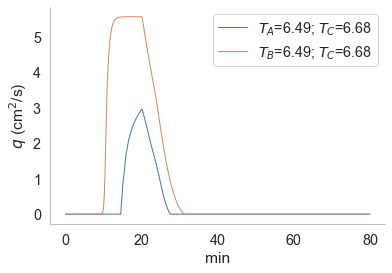

In [64]:
keyA = "H_i--0.1,Ks-5.0/fV-0.6,p-5.0/"
keyB = "H_i-0.0,Ks-5.0/fV-0.6,p-5.0/"


plot_Ta_Tc(keyA, keyB, core, x_f=60)
summary.loc[[keyA, keyB]]

(<Figure size 504x324 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a258cf750>)

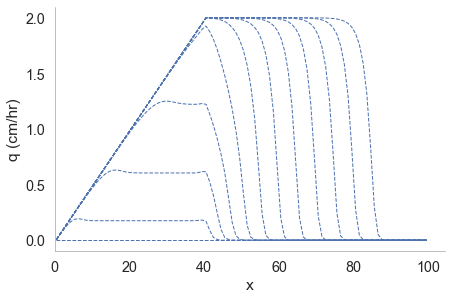

In [65]:
plot_all_profiles(core.loc[keyB], fld= "qc", freq = 10)


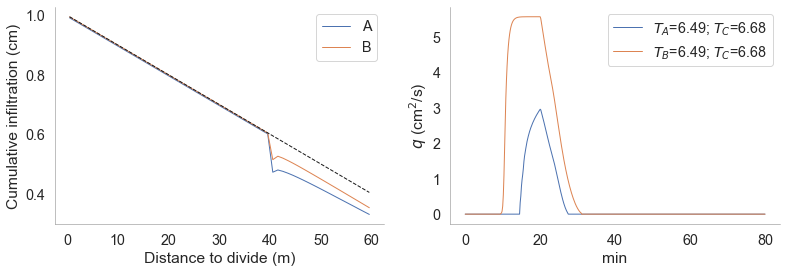

In [73]:
def compare_infl_profile(keyA, keyB, core, ax, x_f = None):
    """
    """
    simA = core.loc[keyA]
    if not x_f :
        x_f = simA.xc.shape[1]-1
#     IF_A = simA.infl_2d[:, :x_f].mean()
    ax.plot(simA.xc[1, :x_f],  
            simA.zc[1, :x_f] - simA.infl_2d[1,:x_f]*2, '-', 
            label = "A")

    simB = core.loc[keyB]
    ax.plot(simB.xc[1, :x_f],  
            simB.zc[1, :x_f] - simB.infl_2d[1,:x_f]*2, '-', 
            label = "B")
    IF_B = simB.infl_2d[:, 20:x_f].mean()

    ax.plot(simB.xc[1, :x_f], simB.zc[1, :x_f], 'k--',lw = 1)
    ax.set_xlabel("Distance to divide (m)")
    ax.set_ylabel("Cumulative infiltration (cm)")
    legend = ax.legend()
    
    plt.setp(legend.get_title(),fontsize='medium')
    
#     ax.legend(title=r"$\alpha_B$", loc="lower left")

fig, axes = plt.subplots(1, 2,  figsize =(13,4))
plt.subplots_adjust(wspace=0.2)

compare_infl_profile(keyA, keyB, core, axes[0], x_f = 60)

# plot_Ta_Tc(keyA, keyB, core, axes[1], ind+2)
plot_Ta_Tc(keyA, keyB, core, x_f=60, ax = axes[1])

In [74]:
# key = "p-3/Ks-3,alphaB-0.1,So-0.01/"
# sim = core.loc[key]


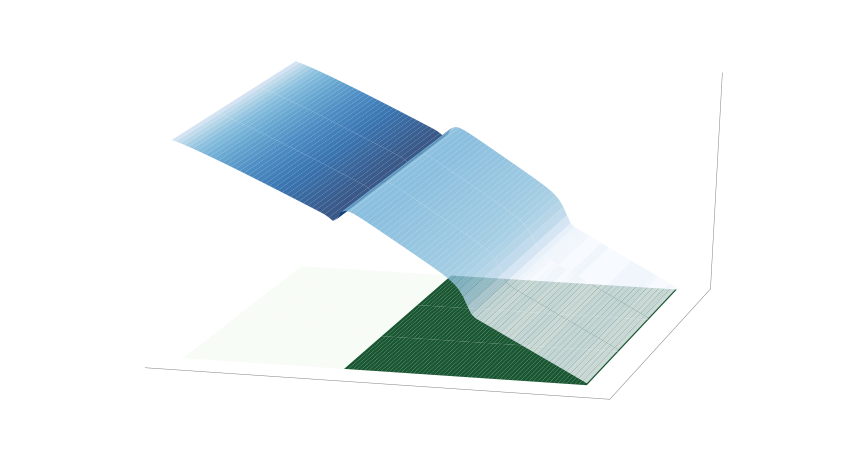

In [181]:
plot_U_surface(sim);

# Relevant to `AC_DC_resolve3` simulations

    fig, ax=plt.subplots(1, figsize = (6,4))
    key =  u'tr-30/alphaB-0.01,alpha-0.05,So-0.02/'

    sim_As_Cs = core.loc[key]
    IF_A = sim_As_Cs.zinflc[:, 20:].mean()
    p = plt.plot(sim_As_Cs.t_p/60, sim_As_Cs.qc1[:, 1]*1e4, '--', lw = 2,
                 label = "{0:.0f}; {1:.0f}".format(sim_As_Cs.t_ac,sim_As_Cs.t_ad))
    blue = p[0].get_color()

    key =   u'tr-30/alphaB-0.01,alpha-0.2,So-0.02/'

    sim_As_Cl = core.loc[key]
    p = plt.plot(sim_As_Cl.t_p/60,sim_As_Cl.qc1[:, 1]*1e4, '--', lw = 2,
                 label = "{0:.0f}; {1:.0f}".format(sim_As_Cl.t_ac,sim_As_Cl.t_ad))
    orange = p[0].get_color()
    plt.legend(title = "$T_A, T_C$ (min)")


    key =   u'tr-30/alphaB-0.2,alpha-0.05,So-0.02/'

    sim_Al_Cs = core.loc[key]

    plt.plot(sim_Al_Cs.t_p/60, sim_Al_Cs.qc1[:, 1]*1e4, c = blue, lw = 2,
             label = "{0:.0f}; {1:.0f}".format(sim_Al_Cs.t_ac,sim_Al_Cs.t_ad))



    key =  u'tr-30/alphaB-0.2,alpha-0.2,So-0.02/'

    sim_Al_Cl = core.loc[key]
    plt.plot(sim_Al_Cl.t_p/60,sim_Al_Cl.qc1[:, 1]*1e4, c = orange, lw = 2,
                 label = "{0:.0f}; {1:.0f}".format(sim_Al_Cl.t_ac,sim_Al_Cl.t_ad))



    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title = "$T_A, T_C$ (min)")

    d = sim.t_rain*sim.rain/sim.ksatV*100
    plt.xlabel("min")
    plt.ylabel("$q$ (cm$^2$/s)")
    plt.xlim(0,50)